# Session 8-1: Multiprocessing, Dask and Xarray

![ntl](./assets/parallel.png)

Recall back to the beginning of the course when we discussed that modern computers have multiple central processing units (CPUs), or cores. Opperating systems, like Windows and Mac OS, are optimized to efficently take advantage of the CPUs on a given system, with hidden subroutines that keep track of CPU loading and RAM allocation. As budding data scientists, we will not go into the details of how a modern computer functions. But we will cover the basics of parallel processing so that you can take advantage of all the CPUs on your system. 

Python has two relatively new packages - [`dask and xarray`](https://docs.xarray.dev/en/stable/user-guide/dask.html) - that enable to processing of gridded datasets in parallel with ease. But to understand how these packages work together, we first need to spend a moment looking at native [`python multiprocessing`](https://docs.python.org/3/library/multiprocessing.html) module.  

A few things to remember. When you launch a **Earth Sciences JupyterLab Classroom** instance of Jupyter on Tempest, the system allocates 8 CPUS and 32GB of RAM (128 GB with high memory) for you to use (FYI - Tempest is one of the largest university clusters in the Northwest, with Tempest currently has 12,264 logical CPU cores, 55.9TB of ECC memory). Thus, if you want to maximize the power of your Jupyter instance, you can have up to 8 CPUs working with 4 GB of RAM (32/8 = 4) or 16 with high memory (128/8 = 16). 

But when tell a CPU to preform a task and it gets allocated a pool of memory, the data being processed on that CPU cannot access the data being processed on another CPU due Python's [Global Interpreter Lock](https://realpython.com/python-gil/). You don't need to understand the GIL in detail for this class. What you do need to know, is that to leverage all the CPUs you need to chunk your data into logical blocks that each CPU can workon without having to talk to the other CPUs. 

This might make you a bit confused. It made me very confused when I started teaching this to myself back in graduate school. The easiest way to learn, as we know is to play some code. So let's do that!

<p style="height:1pt"> </p>

<div class="boxhead2">
    Session Topics
</div>

<div class="boxtext2">
<ul class="a">
    <li> 📌 Introduction to <span class="codeb">multiprocessing</span> </li>
    <ul class="b">
        <li> Census API </li>
        <li> Merging with shapefiles </li>
        <li> Plotting Data </li>
        <li> Area Aggregation </li>
    </ul>
</div>

<hr style="border-top: 0.2px solid gray; margin-top: 12pt; margin-bottom: 0pt"></hr>

### Instructions
We will work through this notebook together. To run a cell, click on the cell and press "Shift" + "Enter" or click the "Run" button in the toolbar at the top. 

<p style="color:#408000; font-weight: bold"> 🐍 &nbsp; &nbsp; This symbol designates an important note about Python structure, syntax, or another quirk.  </p>

<p style="color:#008C96; font-weight: bold"> ▶️ &nbsp; &nbsp; This symbol designates a cell with code to be run.  </p>

<p style="color:#008C96; font-weight: bold"> ✏️ &nbsp; &nbsp; This symbol designates a partially coded cell with an example.  </p>

<hr style="border-top: 1px solid gray; margin-top: 24px; margin-bottom: 1px"></hr>

# multiprocessing

The [`python multiprocessing`](https://docs.python.org/3/library/multiprocessing.html) module is one of the things that make Python such an awesome tool and why Python is among the most popular languages for data science. This is because it make scaling code across CPUs quite easy. We are not going to go deep into the package in this class. But I want to introdroduce you to it, because understanting [`python multiprocessing`](https://docs.python.org/3/library/multiprocessing.html) will make learning [`dask and xarray`](https://docs.xarray.dev/en/stable/user-guide/dask.html) much easier.

To get started, let's start with a simple example. Let's say you have global, daily maximum heat index data for 2016 that you want to convert from celcius to farenheit and then find the global average temperature for each day. In other words, you have 366 (2016 is a leap year) raster files on which you need to preform simple multiplication. These files are pretty large (76mb) and about 9 GB in total data. 

As you will see below, you can do this with a `for` loop. But it will be faster to do this in parallel. Let's take a look

<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [1]:
import os
import glob  
import sys
from multiprocessing import Pool 
import time 
import numpy as np
import rasterio
import multiprocessing
import matplotlib.pyplot as plt

In [2]:
# Get the path to your files in a list files
path = os.path.join('../data/CHC-CMIP6/2016/')
fns = sorted(glob.glob(path + '*.tif'))

# make sure we have 365 or 366 days
print(len(fns))

# print first five files to make sure they are in order
fns[:5]

366


['../data/CHC-CMIP6/2016/himax.2016.01.01.tif',
 '../data/CHC-CMIP6/2016/himax.2016.01.02.tif',
 '../data/CHC-CMIP6/2016/himax.2016.01.03.tif',
 '../data/CHC-CMIP6/2016/himax.2016.01.04.tif',
 '../data/CHC-CMIP6/2016/himax.2016.01.05.tif']

### First, let's take a look at the data
Open one raster and plot it, then look at the meta data to see what the NaN values are so we don't mess those up when we convert °C to °F. 

<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

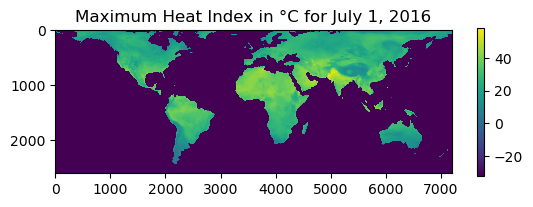

In [3]:
# Let's look at the data for July 1, 2016
arr = rasterio.open(fns[182]).read(1)
plt.imshow(arr, vmin = -32)
plt.colorbar(shrink = 0.4)
plt.title('Maximum Heat Index in °C for July 1, 2016');

In [4]:
# Let's look at the NAN values
rasterio.open(fns[182]).meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -9999.0,
 'width': 7200,
 'height': 2600,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.05000000074505806, 0.0, -180.0,
        0.0, -0.05000000074505806, 70.0)}

### Now Let's try a `for` loop to look at the global average in °F for July. 

Remember, our NaN values is `-9999` so we want to make sure we mask that out when we calculate our global average HI for each day.

<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [5]:
# function to convert c to f
def C_to_F(Tmax_C):
    "Function converts temp in C to F"
    Tmax_F = (Tmax_C * (9/5)) + 32
    
    return Tmax_F

In [13]:
july_fns = fns[182:213]
print(july_fns[0])
print(july_fns[-1])

../data/CHC-CMIP6/2016/himax.2016.07.01.tif
../data/CHC-CMIP6/2016/himax.2016.07.31.tif


In [14]:
# clock it
start = time.time()

for fn in july_fns:
    
    # Get the date
    date = fn.split('himax')[1].split('.tif')[0]
    
    # open the array in c
    arr_c = rasterio.open(fn).read(1)
    
    # covert c to f, using np where so we keep the -9999 values
    arr_f = np.where(arr_c != -9999, C_to_F(arr_c), -9999) # this says, where arr_c does not equal -9999, covert data from c to f, but everwhere else write -9999
    
    # get the daily global average maximum heat index 
    land = arr_f[arr_f != -9999] # drop all ocean -9999 values
    avg = land.mean()
    
    print('On', date, 'the global average heat index was', round(avg, 2), '°F')
    
end = time.time()
print('Time:', end-start)

On .2016.07.01 the global average heat index was 81.22 °F
On .2016.07.02 the global average heat index was 80.66 °F
On .2016.07.03 the global average heat index was 80.74 °F
On .2016.07.04 the global average heat index was 80.79 °F
On .2016.07.05 the global average heat index was 80.54 °F
On .2016.07.06 the global average heat index was 80.41 °F
On .2016.07.07 the global average heat index was 80.94 °F
On .2016.07.08 the global average heat index was 81.68 °F
On .2016.07.09 the global average heat index was 81.62 °F
On .2016.07.10 the global average heat index was 81.55 °F
On .2016.07.11 the global average heat index was 81.21 °F
On .2016.07.12 the global average heat index was 80.88 °F
On .2016.07.13 the global average heat index was 80.74 °F
On .2016.07.14 the global average heat index was 81.0 °F
On .2016.07.15 the global average heat index was 81.12 °F
On .2016.07.16 the global average heat index was 80.87 °F
On .2016.07.17 the global average heat index was 80.83 °F
On .2016.07.18 

### Now try it in parallel. 
Running the code sequentially takes about 33 seconds on one CPU. That's not too bad, but what if you need to do run this calculation 1,000 times? That will add up, and, if you make a mistake, and need to re-run the code, it will set you back even further. This is where parallel processing is super useful. 

Let's see how fast this goes when we feed our list of files to all 8 CPUS. To do this we have to:

1. Create a function to pass to multiprocessing.
2. Create a pool of works (e.g. cpus)
3. Pass our function and list for our works to work on.

<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [15]:
def avg_fast(fn):
    """
    Calculates the average global heat index in Fahrenheit for a given raster file.

    This function:
    1. Extracts the date from the filename.
    2. Reads the heat index data from the raster file in Celsius.
    3. Converts the data from Celsius to Fahrenheit while preserving NaN values 
       (represented by -9999).
    4. Computes the average value of the land-only areas (ignoring ocean values 
       marked as -9999).
    5. Prints the extracted date along with the calculated average heat index.

    Parameters:
    -----------
    fn : str
        The file path of the raster file containing the global heat index data 
        in Celsius. The filename should contain the date in the format 'himax<DATE>.tif'.

    Notes:
    ------
    - This function assumes that NaN values are represented by -9999 in the raster data.
    - The commented-out section allows for optional printing of the process ID 
      (useful for multiprocessing tasks).

    Example:
    --------
    If the raster filename is 'path/to/himax.2024.10.21.tif' and the file contains 
    valid Celsius data:
    
    ```
    On 2024.10.21 the global average heat index was 85.42°F
    ```

    Dependencies:
    -------------
    - numpy as np
    - rasterio
    - A helper function named `C_to_F` to convert Celsius to Fahrenheit.

    """
    
    # you can print your work id
    # print(multiprocessing.current_process())  # for now, we'll leave this commented out
    
    # Get the date
    date = fn.split('himax')[1].split('.tif')[0]
    
    # open the array in c
    arr_c = rasterio.open(fn).read(1)

    # covert c to f, using np where so we keep the -9999 values
    arr_c = np.where(arr_c != -9999, C_to_F(arr_c), -9999) # this says, where arr_c does not equal -9999, covert data from c to f, but everwhere else write -9999
    
    # get the daily global average maximum heat index 
    land_c = arr_c[arr_c != -9999] # drop all ocean -9999 values
    avg_c = land_c.mean()
    
    # print('On', date, 'the global average heat index was', round(avg, 2), '°F \n')
    print(date, avg_c)

In [16]:
# Clock it
start = time.time()

# set up your pool of works, in this case we have 8 
n_cpus = 8 
pool = Pool(processes = n_cpus)

# map the function and the arguments to the pool of works, in this case avg_fast and the list of files
pool.map(avg_fast, july_fns)

# shut down your pool of workers
pool.close()

end = time.time()
print('Time:', end-start)

.2016.07.06.2016.07.05 .2016.07.01.2016.07.0480.413506.2016.07.07  80.53868 
80.79274.2016.07.02
80.93522.2016.07.03
.2016.07.08

  80.74259 81.68253

81.21923
 80.664474.2016.07.13 80.74243.2016.07.10
.2016.07.15.2016.07.11.2016.07.09  81.54616.2016.07.14 .2016.07.12 
 
81.61523481.21042
80.99548 
80.88225
81.11796
.2016.07.16 80.86739.2016.07.17 80.8278

.2016.07.21 82.08344
.2016.07.18.2016.07.20 81.972305
.2016.07.19.2016.07.22 81.78651
  .2016.07.2381.241234 
81.40899
81.336
.2016.07.24 81.10603.2016.07.26
.2016.07.25  81.841194.2016.07.27
 81.45879
81.493805
.2016.07.28 81.29888
.2016.07.29 81.40504
.2016.07.30 81.85863
.2016.07.31 82.10085
Time: 0.7492623329162598


### Some things to think about. 

**Wow!** That was quite a bit faster than one CPU working on the data sequentially.

Notice that the `print` statements from each worker are not printed sequentially. This is because each CPU is working independently and the output is spit out when then the CPU is done. The GIL makes sure that the output from each worker doens't get mixed up, but because this is a relatively small computation for a CPU, there is not enough time delay between tasks for Python to print each output from a worker. 

But if you have each CPU cruch a lot more data, then each worker will will be slowed down enough that the outputs get printed sequentially. Below is a an example where we convert the data from c to f 40 times, to show you what a bigger job looks like. But we are only going to run this on 2 cpus.

In [22]:
def avg_slow(fn):
    
    """
    Calculates the average global heat index in Fahrenheit for a given raster file. But prints out the current_process for each CPU (e.g. worker).

    This function:
    1. Extracts the date from the filename.
    2. Reads the heat index data from the raster file in Celsius.
    3. Converts the data from Celsius to Fahrenheit while preserving NaN values 
       (represented by -9999).
    4. Computes the average value of the land-only areas (ignoring ocean values 
       marked as -9999).
    5. Prints the extracted date along with the calculated average heat index.

    Parameters:
    -----------
    fn : str
        The file path of the raster file containing the global heat index data 
        in Celsius. The filename should contain the date in the format 'himax<DATE>.tif'.

    Notes:
    ------
    - This function assumes that NaN values are represented by -9999 in the raster data.
    - The commented-out section allows for optional printing of the process ID 
      (useful for multiprocessing tasks).

    Example:
    --------
    If the raster filename is 'path/to/himax20241021.tif' and the file contains 
    valid Celsius data:
    
    ```
    On 20241021 the global average heat index was 85.42°F
    ```

    Dependencies:
    -------------
    - numpy as np
    - rasterio
    - A helper function named `C_to_F` to convert Celsius to Fahrenheit.

    """    
    # you can print your work id
    # print(multiprocessing.current_process())  # for now, we'll leave this commented out
    
    # Get the date
    date = fn.split('himax')[1].split('.tif')[0]


    # Conver the data from c to f 10 times to slow everything down   
    for i in list(range(40)):
        
        # open the array in c
        arr_c = rasterio.open(fn).read(1)
        
        # covert c to f, using np where so we keep the -9999 values
        arr_f = np.where(arr_c != -9999, C_to_F(arr_c), -9999) # this says, where arr_c does not equal -9999, covert data from c to f, but everwhere else write -9999
    
    # get the daily global average maximum heat index 
    land_f = arr_f[arr_f != -9999] # drop all ocean -9999 values
    avg_f = land_f.mean()
    
    # print('On', date, 'the global average heat index was', round(avg, 2), '°F \n')
    print(multiprocessing.current_process(), date, avg_f)

In [21]:
# Clock it
start = time.time()

# set up your pool of works, in this case we have 4 
n_cpus = 2 
pool = Pool(processes = n_cpus)

# map the function and the arguments to the pool of works, in this case avg_fast and the list of files
pool.map(avg_slow, july_fns)

# shut down your pool of workers
pool.close()

end = time.time()
print('Time:', end-start)

<ForkProcess name='ForkPoolWorker-14' parent=6350 started daemon> .2016.07.05 80.53868
<ForkProcess name='ForkPoolWorker-13' parent=6350 started daemon> .2016.07.01 81.21923
<ForkProcess name='ForkPoolWorker-14' parent=6350 started daemon> .2016.07.06 80.413506
<ForkProcess name='ForkPoolWorker-13' parent=6350 started daemon> .2016.07.02 80.664474
<ForkProcess name='ForkPoolWorker-14' parent=6350 started daemon> .2016.07.07 80.93522
<ForkProcess name='ForkPoolWorker-13' parent=6350 started daemon> .2016.07.03 80.74259
<ForkProcess name='ForkPoolWorker-14' parent=6350 started daemon> .2016.07.08 81.68253
<ForkProcess name='ForkPoolWorker-13' parent=6350 started daemon> .2016.07.04 80.79274
<ForkProcess name='ForkPoolWorker-14' parent=6350 started daemon> .2016.07.09 81.615234
<ForkProcess name='ForkPoolWorker-13' parent=6350 started daemon> .2016.07.13 80.74243
<ForkProcess name='ForkPoolWorker-14' parent=6350 started daemon> .2016.07.10 81.54616
<ForkProcess name='ForkPoolWorker-13' pa

<hr style="border-top: 1px solid gray; margin-top: 24px; margin-bottom: 1px"></hr>

# Dask & Xarray 

[`python multiprocessing`](https://docs.python.org/3/library/multiprocessing.html) is a great package to use if you want to crunch a bunch of files in parallel. You can even `chunk` datasets and feed lists of chunks to your `Pool` to process data in parallel. But things get more complex when you want the outputs of each CPU's tasks to talk with each other. 

For example, let's say we want to calculate the daily average heat index for each _pixel_ in the dataset. This would require a 3-d array (or cube), where our _x_ and _y_ axes are _longitude_ and _latitude_, respecitively, and our _z_ axis is _time_. Is is possible to open each raster and stack them into a 3-d data cube. But remember, that would require a huge amount of memory since the total data is about 9 GB of data. When we open those rasters, they will balloon because `GeoTiff` files are compressed to some degree too.

![ntl](./assets/data.png)

Welcome to [`Dask and Xarray`](https://docs.xarray.dev/en/stable/user-guide/dask.html)! They will make your life a lot easier. You complete an entire free online tutorial if you want to go deep on `Dask and Xarray`, [An Introduction to Earth and Environmental Data Science](https://earth-env-data-science.github.io/intro.html). Here, we are just going to touch on the basics of both packages, but I **highly** recommend you read about `Xarray` data structures [here](https://docs.xarray.dev/en/stable/user-guide/data-structures.html) because the terminology can be a bit confusing.

![ntl](./assets/xarray.png)

Basically, `Xarray` allows you to create labeled n-dimentional numpy arrays. So you can label your datasets (temperature, precipitation, etc.) and your dimentions (time, lat/long, etc.) to easily subset the data to run analysis. For example, you could say, what is the average heat index in Bozeman based on Lat/Long with just a few lines of code. **Note** We will use the package [`rioxarray`](https://corteva.github.io/rioxarray/html/rioxarray.html) too to load in the GeoTiff files. More on this later. Let's get started!

<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [23]:
# Dependencies 
import xarray as xr
import dask
import rioxarray as rio
import pandas as pd

### A Toy Dataset
Let's start by making two toy data xarray data arrays and turn them into an xarray dataset with temperature and precipitation. They will be 100 by 100 by 30 arrays, representing 100 by 100 lat/long and 30 days.

In [41]:
# make an normally distributed temperature array in degrees f
temp = np.random.normal(loc=60, scale=100, size=(100, 100, 30))
temp.shape

(100, 100, 30)

In [42]:
# make an normally distributed precip array in inches 
precip = (temp - 60) / 40 * 4  # Linearly map [60, 100] to [0, 4]

# Add small noise to array2 to introduce variability while maintaining correlation
noise = np.random.normal(loc=0, scale=0.1, size=(100, 100, 30))
precip = np.clip(precip + noise, 0, 4)  # Ensure values stay within [0, 4]
precip.shape

(100, 100, 30)

In [43]:
# make a 30 day time stamp
time = pd.date_range("2016-01-01", periods=30)
time

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16',
               '2016-01-17', '2016-01-18', '2016-01-19', '2016-01-20',
               '2016-01-21', '2016-01-22', '2016-01-23', '2016-01-24',
               '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28',
               '2016-01-29', '2016-01-30'],
              dtype='datetime64[ns]', freq='D')

In [27]:
len(time)

30

In [44]:
# make x and y index values
x = list(range(1,100+1))
y = list(range(1,100+1))

In [45]:
# Turn temp into xarray data array
temp_da = xr.DataArray(data = temp, # data
                       dims = ['x', 'y', 'time'], # dim labels as a list
                       coords = {'x' : x, 'y' : y, 'time' : time}, # coords data as a dict
                       name = 'temp' # name the da
                      )
temp_da

<xarray.DataArray 'temp' (x: 100, y: 100, time: 30)> Size: 2MB
array([[[ 122.84267445,  -21.11985281,  -38.94621634, ...,
          180.07843179,  166.58083053,  -43.02919714],
        [  96.57929942,   35.60712786,   51.10679448, ...,
           85.50832953,  183.96483473,  160.26699796],
        [  87.31657882,  125.59912856,   50.49602172, ...,
          136.01742522,   77.15815598,  147.07819842],
        ...,
        [  95.83771816,   76.99160787,   -6.00694281, ...,
          153.77877744,   15.74052399,   88.72083804],
        [  22.03488626,  -44.44803106,   -0.65781015, ...,
          -81.55426783,  -31.09582487,  118.99781484],
        [ 355.95238278,   53.27655042,  106.59214624, ...,
           64.00238939,  -57.78516416,  -22.91945822]],

       [[-113.09155269,  126.65560852,  -79.62021671, ...,
          -71.22759411,  -42.90115311,   -8.674747  ],
        [  22.21101507,  254.92865184,  214.82054357, ...,
            6.23764069,   79.06203462,   48.13515227],
        [   2.85866365,  267.2948134 ,  -36.46483348, ...,
          275.64348443,   66.59922966,   18.45917321],
...
        [ 100.9467883 ,  337.12974184,   -0.98866492, ...,
          126.76538304,  -63.13518036,   -2.85420196],
        [ -51.60075107,  129.34204462,  -10.25302645, ...,
          146.60200522,   72.49290211,  -23.44091833],
        [ -33.92729132,  114.16154687,    9.89010342, ...,
           80.00688011,  193.7109987 ,   46.89936714]],

       [[  63.93112755,    4.540101  ,  110.64961398, ...,
           32.22068933,   33.52735569,  120.0095037 ],
        [ 287.53281682,   53.07964979,  -63.61947842, ...,
          149.69245881,   94.04188949,  -83.62381975],
        [ 110.14321627, -101.02167732,   90.01751557, ...,
          205.99892741,   44.92006108,   -2.85033659],
        ...,
        [ 223.8066435 ,  110.75752165,  -37.52720604, ...,
          -56.58813538,  338.7210431 ,  -80.25218479],
        [  64.96640565,  178.4809135 ,   82.49048809, ...,
          113.92540898,   -8.35465246,   86.56924142],
        [ -55.62052935,  -45.01521281,  168.51553636, ...,
           58.56803657,   52.59751683, -114.31383596]]])
Coordinates:
  * x        (x) int64 800B 1 2 3 4 5 6 7 8 9 10 ... 92 93 94 95 96 97 98 99 100
  * y        (y) int64 800B 1 2 3 4 5 6 7 8 9 10 ... 92 93 94 95 96 97 98 99 100
  * time     (time) datetime64[ns] 240B 2016-01-01 2016-01-02 ... 2016-01-30

In [30]:
# Turn precip into xarray data array
precip_da = xr.DataArray(data = precip, # data
                       dims = ['x', 'y', 'time'], # dim labels as a list
                       coords = {'x' : x, 'y' : y, 'time' : time}, # coords data as a dict
                       name = 'precip' # name the da
                      )
precip_da

<xarray.DataArray 'precip' (x: 100, y: 100, time: 30)> Size: 2MB
array([[[7, 3, 9, ..., 8, 4, 2],
        [9, 5, 5, ..., 4, 7, 1],
        [1, 5, 3, ..., 9, 6, 9],
        ...,
        [0, 4, 3, ..., 8, 9, 4],
        [4, 9, 9, ..., 3, 5, 4],
        [6, 1, 1, ..., 1, 7, 7]],

       [[3, 2, 7, ..., 3, 6, 8],
        [4, 6, 8, ..., 2, 7, 2],
        [7, 2, 8, ..., 8, 6, 6],
        ...,
        [0, 4, 1, ..., 8, 4, 0],
        [6, 2, 1, ..., 5, 5, 3],
        [5, 1, 2, ..., 2, 7, 0]],

       [[1, 7, 2, ..., 3, 9, 5],
        [3, 6, 3, ..., 1, 6, 2],
        [7, 7, 5, ..., 5, 7, 4],
        ...,
...
        ...,
        [7, 0, 5, ..., 9, 9, 2],
        [1, 3, 9, ..., 4, 5, 4],
        [8, 6, 4, ..., 4, 3, 4]],

       [[6, 8, 0, ..., 0, 7, 2],
        [2, 5, 2, ..., 8, 7, 5],
        [5, 5, 6, ..., 9, 9, 8],
        ...,
        [3, 7, 5, ..., 5, 9, 5],
        [3, 0, 1, ..., 5, 1, 9],
        [1, 9, 4, ..., 6, 0, 9]],

       [[7, 5, 3, ..., 0, 9, 1],
        [5, 7, 0, ..., 3, 7, 1],
        [9, 2, 0, ..., 2, 8, 6],
        ...,
        [3, 5, 7, ..., 5, 7, 9],
        [3, 8, 5, ..., 8, 9, 4],
        [6, 0, 6, ..., 0, 2, 0]]])
Coordinates:
  * x        (x) int64 800B 1 2 3 4 5 6 7 8 9 10 ... 92 93 94 95 96 97 98 99 100
  * y        (y) int64 800B 1 2 3 4 5 6 7 8 9 10 ... 92 93 94 95 96 97 98 99 100
  * time     (time) datetime64[ns] 240B 2016-01-01 2016-01-02 ... 2016-01-30

In [46]:
# Now combine temp and precip into a dataset
ds = xr.merge([temp_da, precip_da])
ds

<xarray.Dataset> Size: 5MB
Dimensions:  (x: 100, y: 100, time: 30)
Coordinates:
  * x        (x) int64 800B 1 2 3 4 5 6 7 8 9 10 ... 92 93 94 95 96 97 98 99 100
  * y        (y) int64 800B 1 2 3 4 5 6 7 8 9 10 ... 92 93 94 95 96 97 98 99 100
  * time     (time) datetime64[ns] 240B 2016-01-01 2016-01-02 ... 2016-01-30
Data variables:
    temp     (x, y, time) float64 2MB 122.8 -21.12 -38.95 ... 58.57 52.6 -114.3
    precip   (x, y, time) int64 2MB 7 3 9 8 2 4 5 8 4 4 ... 4 3 6 7 8 9 5 0 2 0

#### A bit about Xarray Datasets

Xarray Datasets are nice because you can easily stack several data arrays and run analysis on the data. Like numpy arrays, they must be the same size. But unlike numpy arrays, you have labels, so it is easy to subset the data.

In [32]:
# access the temp data
ds.temp

<xarray.DataArray 'temp' (x: 100, y: 100, time: 30)> Size: 2MB
array([[[88, 88, 80, ..., 64, 63, 26],
        [72, 87, 86, ..., 92, 82, 31],
        [92, 52, 71, ..., 85, 94, 30],
        ...,
        [66, 33, 53, ..., 51, 51, 36],
        [64, 85, 64, ..., 49, 42, 98],
        [20, 31, 88, ..., 86, 79, 40]],

       [[21, 77, 28, ..., 92, 63, 96],
        [81, 22, 20, ..., 35, 60, 28],
        [86, 98, 51, ..., 59, 31, 79],
        ...,
        [62, 83, 72, ..., 99, 46, 90],
        [43, 65, 44, ..., 55, 59, 66],
        [36, 95, 54, ..., 28, 33, 80]],

       [[71, 24, 86, ..., 32, 21, 78],
        [52, 23, 91, ..., 36, 98, 61],
        [80, 23, 20, ..., 27, 47, 31],
        ...,
...
        ...,
        [93, 93, 43, ..., 45, 29, 50],
        [52, 86, 87, ..., 24, 93, 23],
        [24, 58, 96, ..., 90, 26, 76]],

       [[81, 31, 75, ..., 49, 28, 91],
        [98, 32, 29, ..., 30, 90, 99],
        [61, 91, 21, ..., 58, 25, 75],
        ...,
        [84, 51, 91, ..., 44, 99, 74],
        [98, 53, 46, ..., 86, 70, 29],
        [22, 92, 49, ..., 81, 51, 59]],

       [[37, 22, 95, ..., 81, 20, 36],
        [49, 50, 82, ..., 26, 29, 30],
        [93, 72, 66, ..., 80, 78, 36],
        ...,
        [51, 24, 61, ..., 22, 64, 35],
        [53, 34, 60, ..., 25, 82, 96],
        [40, 82, 67, ..., 38, 77, 52]]])
Coordinates:
  * x        (x) int64 800B 1 2 3 4 5 6 7 8 9 10 ... 92 93 94 95 96 97 98 99 100
  * y        (y) int64 800B 1 2 3 4 5 6 7 8 9 10 ... 92 93 94 95 96 97 98 99 100
  * time     (time) datetime64[ns] 240B 2016-01-01 2016-01-02 ... 2016-01-30

In [33]:
# access the precip data
ds.precip 

<xarray.DataArray 'precip' (x: 100, y: 100, time: 30)> Size: 2MB
array([[[7, 3, 9, ..., 8, 4, 2],
        [9, 5, 5, ..., 4, 7, 1],
        [1, 5, 3, ..., 9, 6, 9],
        ...,
        [0, 4, 3, ..., 8, 9, 4],
        [4, 9, 9, ..., 3, 5, 4],
        [6, 1, 1, ..., 1, 7, 7]],

       [[3, 2, 7, ..., 3, 6, 8],
        [4, 6, 8, ..., 2, 7, 2],
        [7, 2, 8, ..., 8, 6, 6],
        ...,
        [0, 4, 1, ..., 8, 4, 0],
        [6, 2, 1, ..., 5, 5, 3],
        [5, 1, 2, ..., 2, 7, 0]],

       [[1, 7, 2, ..., 3, 9, 5],
        [3, 6, 3, ..., 1, 6, 2],
        [7, 7, 5, ..., 5, 7, 4],
        ...,
...
        ...,
        [7, 0, 5, ..., 9, 9, 2],
        [1, 3, 9, ..., 4, 5, 4],
        [8, 6, 4, ..., 4, 3, 4]],

       [[6, 8, 0, ..., 0, 7, 2],
        [2, 5, 2, ..., 8, 7, 5],
        [5, 5, 6, ..., 9, 9, 8],
        ...,
        [3, 7, 5, ..., 5, 9, 5],
        [3, 0, 1, ..., 5, 1, 9],
        [1, 9, 4, ..., 6, 0, 9]],

       [[7, 5, 3, ..., 0, 9, 1],
        [5, 7, 0, ..., 3, 7, 1],
        [9, 2, 0, ..., 2, 8, 6],
        ...,
        [3, 5, 7, ..., 5, 7, 9],
        [3, 8, 5, ..., 8, 9, 4],
        [6, 0, 6, ..., 0, 2, 0]]])
Coordinates:
  * x        (x) int64 800B 1 2 3 4 5 6 7 8 9 10 ... 92 93 94 95 96 97 98 99 100
  * y        (y) int64 800B 1 2 3 4 5 6 7 8 9 10 ... 92 93 94 95 96 97 98 99 100
  * time     (time) datetime64[ns] 240B 2016-01-01 2016-01-02 ... 2016-01-30

In [47]:
# Estimate correlation between precip and temperature over time
corr = xr.corr(ds.temp, ds.precip, dim= 'time')
corr

<xarray.DataArray (x: 100, y: 100)> Size: 80kB
array([[-0.28529263,  0.0524318 ,  0.22970603, ...,  0.03814235,
        -0.23968401, -0.20248443],
       [ 0.1274467 , -0.15238111,  0.10087859, ..., -0.21359893,
         0.31224815, -0.3028335 ],
       [ 0.48312292,  0.17309085, -0.04170931, ..., -0.41116702,
        -0.16355313, -0.00886544],
       ...,
       [-0.20536926,  0.15791144,  0.02345446, ..., -0.37751711,
        -0.02598705,  0.45321098],
       [ 0.21099038, -0.08361677,  0.22604778, ..., -0.01678187,
        -0.1452463 , -0.05840112],
       [ 0.09367574, -0.1087274 , -0.31777713, ..., -0.19578501,
        -0.38740776,  0.0289341 ]])
Coordinates:
  * x        (x) int64 800B 1 2 3 4 5 6 7 8 9 10 ... 92 93 94 95 96 97 98 99 100
  * y        (y) int64 800B 1 2 3 4 5 6 7 8 9 10 ... 92 93 94 95 96 97 98 99 100

Text(0.5, 1.0, 'Correlation Between Simulated Temp. and Precip')

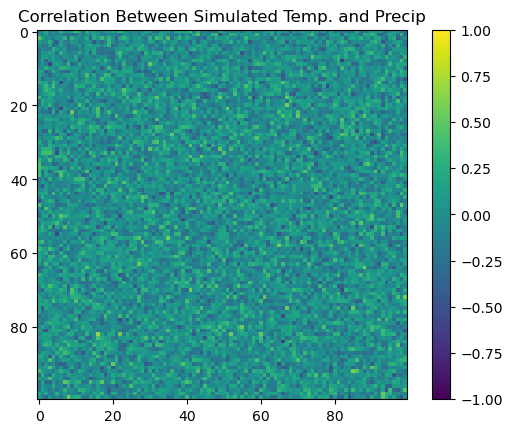

In [51]:
# plot the correlation
plt.imshow(corr, vmin = -1, vmax = 1)
plt.colorbar()
plt.title('Correlation Between Simulated Temp. and Precip')

## Let's look at some real data with Dask

Using `Xarray` and `Dask` together is really powerful. Be sure to read this [overview](https://docs.xarray.dev/en/stable/user-guide/dask.html) on your own time. But the short of it is that `Dask` allows you to create `chunks` of large datasets that are small enough to load into memory, without loading all the data into memory. When used with `xarray`, you can set up a instructions (e.g. computations) to run on `Xarray` object that Python will complete in parallel without actually loading the dataset into memory. Confused? I was too. The easiest way to learn this, is to actually do it. 

Let's look at an example with our heat index data from 2016 that is nearly 9 GB.

<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [ ]:
# Get the path to your files in a list files
path = os.path.join('/home/group/earthsciences/gphy591/github/GPHY-491-591/materials/Day8/data/2016/')
fns = sorted(glob.glob(path + '*.tif'))

# print first five files to make sure they are in order
fns[:5]

#### Load a 'view' of all 366 files into a Xarray DataSet

The code below will not load the files into memory, but it will create a DataSet on which we can look at what the data would be if it were loaded into memory, set up a set of instructions, and then tell `Dask` to run the instructions in parallel.

Like python `multiprocessing`, you first have to tell `Dask` to tee up 8 CPUS. If you run this on your on machine, `Dask` creates a URL where you can watch your workers work. More on this later.

<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [ ]:
# Dependencies 
from dask.distributed import Client, LocalCluster

In [ ]:
# create and connect to a dash cluster + get link to watch progress
client = Client(n_workers = 8)
client

In [ ]:
# Now 'load' the GeoTif Files
da = xr.concat([rio.open_rasterio(f, chunks = 'auto') for f in fns], dim='band') 

In [ ]:
# Take a look at your DataArray
da

In [ ]:
# How big is the da object?
sys.getsizeof(da)

As you see, the da object is **REALLY** small. That is because the data is not actually in memory. `Dask` has chunked the data for us so it will run in parallel using `auto` argument, where `dask` figures out the optimal size of the chunk give our CPUs and available memory.

### Updating Data
We can update information about our data array, like renaming `band` to time and we can add a `Pandas` time series to the `time` dimention as coordinates, again without actually loading the data into memory.

In [ ]:
# Make a pandas time daily time series for 2016
time = time = pd.date_range("2016-01-01", periods=366)
time

In [ ]:
# rename time dim
da = da.rename({'band' : 'time'})
da

In [ ]:
# Revalue the time' coord
da.coords['time'] = time
da

### Subsetting data

There are tons of ways to slice Xarray Data Arrays. Here are two examples.

In [ ]:
# Select by month (e.g. January)
jan = da.where(da['time.month'] == 1, drop = True)
jan

In [ ]:
# Select by set by col / row
subset = da[:, 1000:1500, 3000:4000] # subset for west africa
subset

In [ ]:
# Slice by lat / long
subset = da.sel(x = slice(-30,19), y = slice(20, -5))
subset

### Average Heat Index
Now, let's calculate the daily and monthly maximum heat index for 2016 with dask! Again, nothing is actually being computed, until you add `.compute()` to the data array. Check out the code below to understand.

In [ ]:
# Estimate the mean daily max heat index along the time dim
daily_avg = da.mean(dim = 'time')
daily_avg

In [ ]:
# Now run the code again with .compute() added
daily_avg = da.mean(dim = 'time').compute()
daily_avg

In [ ]:
# plot it 
arr = daily_avg.data
plt.imshow(arr, vmin = -32)
plt.colorbar(shrink = 0.3)
plt.title('Average Daily Maximum Heat Index for 2016');

### Save your the daily average heat index for 2016 as a tif file

In [ ]:
# get the meta data
meta = rasterio.open(fns[0]).meta

In [ ]:
# make a file name
fn_out = os.path.join('./himax_2016_avg.tif')

In [ ]:
# save it 
with rasterio.open(fn_out, "w", **meta) as dest:
    dest.write(arr, 1)

In [ ]:
# Check it
plt.imshow(rasterio.open(fn_out).read(1), vmin = -32);

### 